# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    project_config.pop
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
project_config['STOCKS'] = project_config['STOCKS'].split()
project_config['TKL'] = project_config['STOCKS'][0]

In [4]:
if project_config['chain_notebooks'] == '1':

  !pip install papermill
  !pip install nbconvert
  !pip install nbformat
  !pip install IPython

  import papermill as pm
  import nbformat
  from nbconvert import HTMLExporter
  from IPython.display import HTML, display

  input_file = f"{os.getenv('PROJECT_PATH')}{project_config['notebooks_directory']}{project_config['notebook1']}"
  output_file = f"{os.getenv('PROJECT_PATH')}{project_config['output_directory']}{project_config['output1']}"

  # --- Execute the proviuse notebook with parameters ---
  pm.execute_notebook(
      input_path = input_file,
      output_path = output_file,
      log_output=False,  # don't print logs while running
      progress_bar=True
  )

  # --- Convert the executed notebook to HTML ---
  nb = nbformat.read(output_file, as_version=4)
  html_exporter = HTMLExporter()
  html_exporter.template_name = "lab"  # modern look; alternatives: 'classic', 'basic'
  body, _ = html_exporter.from_notebook_node(nb)

  # --- Display the HTML result inline ---
  display(HTML(body))

# Dowload a Ticker and exhogen indexes from Yahoo

In [5]:
tickers_yf = {
    "y"     : f"{project_config['TKL']}",
    "NASDAQ"       : "^IXIC",
    "SP500"        : "^GSPC",
    "Gold"         : "GC=F",
    "Oil"          : "CL=F",
    "RealEstate"   : "VNQ",
    "InflationExp": "^TNX"
}

desired_order = [
    "Date",
    "y",
    "NASDAQ",
    "SP500",
    "Oil",
    "Gold",
    "RealEstate",
    "InflationExp",
]

In [6]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

if project_config['TKL'] == 'TNYA':
  start_date = pd.to_datetime("31.07.2022", format="%d.%m.%Y")

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# Fill missing daily values for macro data (monthly)
ts_yf = ts_yf.fillna(method='ffill').fillna(method='bfill')
ts_yf = ts_yf.reset_index().rename(columns={"Date": "Date",})

print(f"\n\nDataset for y={project_config['TKL']}")
display(ts_yf.head(1))
display(ts_yf.tail(1))
ts_yf.info()

[*********************100%***********************]  7 of 7 completed



Dataset for y=AAPL


Ticker,Date,y,Oil,Gold,RealEstate,SP500,NASDAQ,InflationExp
0,2006-10-19,2.368992,58.5,599.0,33.746399,1366.959961,2340.939941,4.786


Ticker,Date,y,Oil,Gold,RealEstate,SP500,NASDAQ,InflationExp
4823,2025-12-17,271.839996,55.939999,4347.5,89.400002,6721.430176,22693.320312,4.151


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4824 non-null   datetime64[ns]
 1   y             4824 non-null   float64       
 2   Oil           4824 non-null   float64       
 3   Gold          4824 non-null   float64       
 4   RealEstate    4824 non-null   float64       
 5   SP500         4824 non-null   float64       
 6   NASDAQ        4824 non-null   float64       
 7   InflationExp  4824 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 301.6 KB


# Data prep. Time series for ML/XGB

In [7]:
df = ts_yf.copy()
df_orig = ts_yf.copy()

# Keep Date
date_col = df["Date"]

# Targets
y_col = ['y']

# Features
X_cols = df.drop(columns=y_col+['Date']).columns

# Initialize scalers
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Scale
df_X_scaled = pd.DataFrame(X_scaler.fit_transform(df[X_cols]),
                           columns=X_cols, index=df.index)

df_y_scaled = pd.DataFrame(y_scaler.fit_transform(df[y_col]),
                           columns=y_col, index=df.index)

# Rebuild dataframe
df = pd.concat([date_col, df_X_scaled, df_y_scaled], axis=1)

df = df[desired_order]
df_orig = df_orig[desired_order]

del df_X_scaled, df_y_scaled

display(df.tail(1))
display(df_orig.tail(1))

,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp
4823,2025-12-17,0.949444,0.944242,0.971151,0.511535,1.0,0.880862,0.769004


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp
4823,2025-12-17,271.839996,22693.320312,6721.430176,55.939999,4347.5,89.400002,4.151


In [8]:
def generate_ts_features(df, lags=[2,3,4,5,6,10,22,66], windows=[5,10,22,66]):

  # Identify columns to generate features for (excluding 'index' column which is the date)
  base_cols = [c for c in df.columns if c not in ['Date','index']]

  for base_col in base_cols:

    for lag in lags:
      df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
    for window in windows:
      df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
      df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
      df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
      df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
      df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
      df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)

  df['y_next'] = df['y'].shift(-1)                            # y_next = tomorrow's y (close price)
  df.loc[df.index[-1], 'y_next'] = df.loc[df.index[-1], 'y']  # the TARGET cell. y_next tomorrow = y today
  df = df.fillna(method='ffill').fillna(method='bfill')

  return df

df = generate_ts_features(df)
df_orig = generate_ts_features(df_orig)

# Replace infinite values with NaN in X_train and y_train
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(method='ffill').fillna(method='bfill')

display(df.tail(1))
display(df_orig.tail(1))

,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp,y_lag_2,y_lag_3,...,InflationExp_std_22,InflationExp_diff_22,InflationExp_pct_22,InflationExp_min_66,InflationExp_max_66,InflationExp_mean_66,InflationExp_std_66,InflationExp_diff_66,InflationExp_pct_66,y_next
4823,2025-12-17,0.949444,0.944242,0.971151,0.511535,1.0,0.880862,0.769004,0.957441,0.972133,...,0.012571,0.000632,0.000822,0.727311,0.778058,0.756631,0.013266,0.024637,0.033098,0.949444


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp,y_lag_2,y_lag_3,...,InflationExp_std_22,InflationExp_diff_22,InflationExp_pct_22,InflationExp_min_66,InflationExp_max_66,InflationExp_mean_66,InflationExp_std_66,InflationExp_diff_66,InflationExp_pct_66,y_next
4823,2025-12-17,271.839996,22693.320312,6721.430176,55.939999,4347.5,89.400002,4.151,274.109985,278.279999,...,0.059699,0.003,0.000723,3.953,4.194,4.092242,0.062998,0.117,0.029003,271.839996


# Select features using XGB's featrure importance

In [9]:
X = df.drop(columns=['Date','y_next'])
y = df['y_next']

X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]

del X,y

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4822, 231), (1, 231), (4822,), (1,))

In [10]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
pred = xgb.predict(X_test)
pred_orig = y_scaler.inverse_transform(pred.reshape(-1, 1))[0, 0] # Corrected to use NumPy indexing

df.loc[df.index[-1], 'y_next'] = pred
df_orig.loc[df_orig.index[-1], 'y_next'] = pred_orig

print(f"{project_config['TKL']} {df['Date'].iloc[-1].date()} ${pred_orig:.2f}")
display(df.tail(1))
display(df_orig.tail(1))

AAPL 2025-12-17 $275.66


,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp,y_lag_2,y_lag_3,...,InflationExp_std_22,InflationExp_diff_22,InflationExp_pct_22,InflationExp_min_66,InflationExp_max_66,InflationExp_mean_66,InflationExp_std_66,InflationExp_diff_66,InflationExp_pct_66,y_next
4823,2025-12-17,0.949444,0.944242,0.971151,0.511535,1.0,0.880862,0.769004,0.957441,0.972133,...,0.012571,0.000632,0.000822,0.727311,0.778058,0.756631,0.013266,0.024637,0.033098,0.962892


Ticker,Date,y,NASDAQ,SP500,Oil,Gold,RealEstate,InflationExp,y_lag_2,y_lag_3,...,InflationExp_std_22,InflationExp_diff_22,InflationExp_pct_22,InflationExp_min_66,InflationExp_max_66,InflationExp_mean_66,InflationExp_std_66,InflationExp_diff_66,InflationExp_pct_66,y_next
4823,2025-12-17,271.839996,22693.320312,6721.430176,55.939999,4347.5,89.400002,4.151,274.109985,278.279999,...,0.059699,0.003,0.000723,3.953,4.194,4.092242,0.062998,0.117,0.029003,275.657227


<Figure size 1000x600 with 0 Axes>

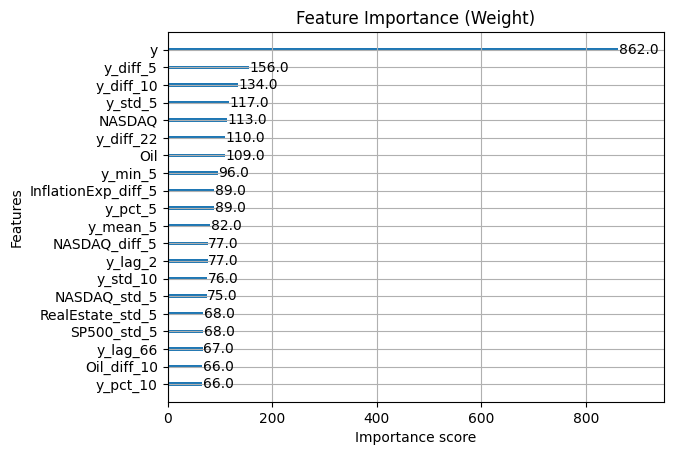

Weight Threshold: 43.1
Selected Weight Features: ['y', 'y_diff_5', 'y_diff_10', 'y_std_5', 'NASDAQ', 'y_diff_22', 'Oil', 'y_min_5', 'y_pct_5', 'InflationExp_diff_5']


In [12]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# 1. Get feature importance by weight
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to DataFrame
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort high → low
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Compute threshold = 10% of top feature
top_score = df_importance['Score'].iloc[0]
threshold = top_score * 0.05   # 5%

# 5. Select only strong features
df_top = df_importance[df_importance['Score'] >= threshold]

# 6. Convert to list
top_weight_features_list = df_top['Feature'].tolist()[:10:]

print("Weight Threshold:", threshold)
print("Selected Weight Features:", top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

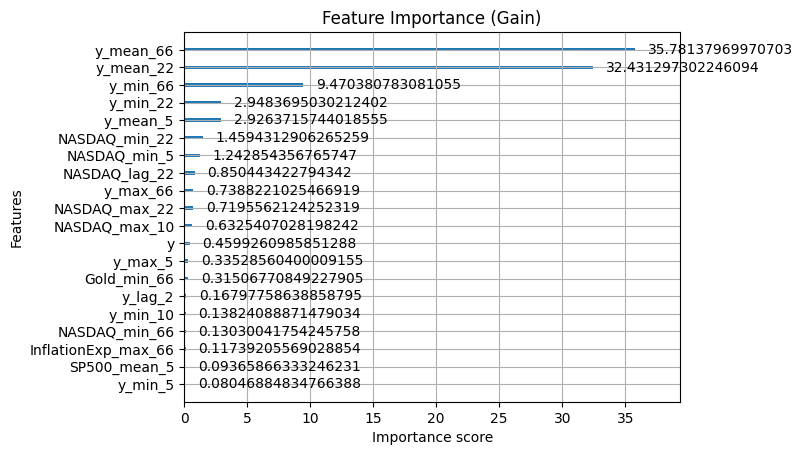

Threshold: 1.7890689849853516
Selected features: ['y_mean_66', 'y_mean_22', 'y_min_66', 'y_min_22', 'y_mean_5']


In [13]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# 1. Build importance DataFrame
importance_dict = xgb.get_booster().get_score(importance_type='gain')
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 2. Sort high to low
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 3. Compute threshold = 10% of top feature
top_score = df_importance['Score'].iloc[0]
threshold = top_score * 0.05

# 4. Select features with Score >= threshold
df_top = df_importance[df_importance['Score'] >= threshold]

# 5. Extract feature names
top_gain_features_list = df_top['Feature'].tolist()[:10:]

print("Threshold:", threshold)
print("Selected features:", top_gain_features_list)

In [14]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['y_diff_5',
 'y_mean_66',
 'y_min_22',
 'y_mean_22',
 'y_std_5',
 'Oil',
 'y_pct_5',
 'y_mean_5',
 'y_min_5',
 'y_diff_22',
 'y_diff_10',
 'y',
 'y_min_66',
 'NASDAQ',
 'InflationExp_diff_5']

# df with selected features to CSV

In [15]:
final_df = df[['Date','y_next'] + top_features]

for col in top_features + ['y_next']:
  final_df[f"{col}_orig"] = df_orig[col]

display(final_df.tail(1))
final_df.info()

,Date,y_next,y_diff_5,y_mean_66,y_min_22,y_mean_22,y_std_5,Oil,y_pct_5,y_mean_5,...,y_pct_5_orig,y_mean_5_orig,y_min_5_orig,y_diff_22_orig,y_diff_10_orig,y_orig,y_min_66_orig,NASDAQ_orig,InflationExp_diff_5_orig,y_next_orig
4823,2025-12-17,0.962892,-0.02445,0.923794,0.92975,0.964441,0.009676,0.511535,-0.025105,0.961895,...,-0.024894,275.373993,271.839996,-0.570007,-12.309998,271.839996,237.649628,22693.320312,-0.013,275.657227


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      4824 non-null   datetime64[ns]
 1   y_next                    4824 non-null   float64       
 2   y_diff_5                  4824 non-null   float64       
 3   y_mean_66                 4824 non-null   float64       
 4   y_min_22                  4824 non-null   float64       
 5   y_mean_22                 4824 non-null   float64       
 6   y_std_5                   4824 non-null   float64       
 7   Oil                       4824 non-null   float64       
 8   y_pct_5                   4824 non-null   float64       
 9   y_mean_5                  4824 non-null   float64       
 10  y_min_5                   4824 non-null   float64       
 11  y_diff_22                 4824 non-null   float64       
 12  y_diff_10           

In [16]:
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
final_df[:-1:].to_csv(df_csv_path)

# Load dataset file of current TKL

In [17]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for AAPL .....


df for training
-----------------


,Date,y_next,y_diff_5,y_mean_66,y_min_22,y_mean_22,y_std_5,Oil,y_pct_5,y_mean_5,y_min_5,y_diff_22,y_diff_10,y,y_min_66,NASDAQ,InflationExp_diff_5
4822,2025-12-16,0.949444,-0.009054,0.921906,0.92975,0.964532,0.007808,0.507872,-0.009351,0.966785,0.957441,0.005848,-0.040797,0.959203,0.824836,0.96267,-0.007791



df for visualization
----------------------


,Date,y_diff_5_orig,y_mean_66_orig,y_min_22_orig,y_mean_22_orig,y_std_5_orig,Oil_orig,y_pct_5_orig,y_mean_5_orig,y_min_5_orig,y_diff_22_orig,y_diff_10_orig,y_orig,y_min_66_orig,NASDAQ_orig,InflationExp_diff_5_orig,y_next_orig
4822,2025-12-16,-2.570007,264.023396,266.25,276.122726,2.216349,55.27,-0.009272,276.761993,274.109985,1.659973,-11.580017,274.609985,236.470764,23111.460938,-0.037,271.839996


# Data prep. Time series for AI/NN

In [18]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

# Racing models (listed in src/config.json)

In [19]:
def train_predict(X_train, X_test, y_train, y_test, features, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import LSTM, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Concatenate

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'Parallel.LSTM.GRU':
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))
    lstm_branch = LSTM(units=50, return_sequences=False)(input_layer)
    gru_branch = GRU(units=50, return_sequences=False)(input_layer)
    merged = Concatenate()([lstm_branch, gru_branch])
    dropout = Dropout(0.1, name='dropout_layer')(merged)
    output_layer = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=input_layer, outputs=output_layer)

  if model_name == 'Cascase.CNN.GRU':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        GRU(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'Cascase.CNN.LSTM':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=False),
        Dense(25, activation='relu'),
        Dense(1)
  ])

  if model_name == 'CNN':
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)
  ])

  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
  ])

  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
  ])

  model.compile(optimizer='adam', loss='mse')

  print("\n=====================================================================\n")
  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  model.summary()

  history = model.fit(X_train, y_train,
                      epochs=int(project_config['TRAIN_EPOCS']),
                      batch_size=int(project_config['TRAIN_BATCH_SIZE']),
                      validation_data=(X_test, y_test),
                      verbose=1)

  pred = model.predict(X_test)
  unscaled_prediction = y_scaler.inverse_transform(pred.reshape(-1, 1))
  unscaled_y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)

  print(f"TKL: {project_config['TKL']}")
  print(f"Model: {model_name}")
  print(f"Features: {features}")
  print(f"MAE: {mae:.4f}")
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [20]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

def race_models(tkl, models_to_try):

  results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

  for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

    X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

    if 'Parallel.LSTM.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Parallel.LSTM.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Parallel.LSTM.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'Cascase.CNN.LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="Cascase.CNN.LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "Cascase.CNN.LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'CNN' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="CNN")
      results_df.loc[len(results_df)] = {
        "model_name": "CNN",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
        }

    if 'GRU' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="GRU")
      results_df.loc[len(results_df)] = {
        "model_name": "GRU",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

    if 'LSTM' in models_to_try:
      unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, X_cols, model_name="LSTM")
      results_df.loc[len(results_df)] = {
        "model_name": "LSTM",
        "X_cols": X_cols,
        "prediction": unscaled_prediction,
        "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
        "r2": r2_score(unscaled_y_test, unscaled_prediction),
        "model": model
      }

  return results_df, dates_test, unscaled_y_test

In [22]:
def plot_results(results_df, dates_test, unscaled_y_test):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(10,6))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(10,6))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual", linewidth=2, color='black')

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}", linestyle='--')

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

In [23]:
# def predict_next_days(winning_model, winning_model_name, winning_model_features, future_days=10):

#   # Re-create X_train, X_test, y_train, y_test, dates_test with the winning model's features
#   # This ensures that X_test has the correct number of features for the winning_model.
#   X_train_winning, X_test_winning, y_train_winning, y_test_winning, dates_test_winning = make_datasets(df, winning_model_features, y_col)

#   last_historical_block = X_test_winning[-1:] # Select the last sequence from X_test_winning
#   last_historical_day = df.iloc[-1].Date
#   future_rolling_block = last_historical_block.copy()
#   future_predictions = []

#   for _ in range(future_days):

#     next_pred_day = winning_model.predict(future_rolling_block)[0]
#     future_predictions.append(next_pred_day)
#     # To simulate new data, shift the window and replace the last element with the new prediction
#     # The new prediction (next_pred_day) represents 'y_next', so it becomes the 'y' feature
#     # in the next time step's input block. Other features would need to be synthesized or assumed.
#     # For simplicity and given the model was trained on ['y', 'NASDAQ'] with 'y_next' as target,
#     # we need to ensure the rolling block maintains the correct feature structure.
#     # The error suggests a feature mismatch, so for a simple 'y' and 'NASDAQ' model,
#     # we need to ensure 'future_rolling_block' is updated correctly.

#     # The original implementation `future_rolling_block[:, -1, 0] = next_pred_day`
#     # implicitly assumes a single feature is being updated, which is correct for
#     # a model trained on only ['y']. For a model trained on ['y', 'NASDAQ'],
#     # if 'y' is the first feature (index 0) and 'NASDAQ' is the second (index 1),
#     # we can update the 'y' feature and either leave 'NASDAQ' as is or synthesize it.
#     # Given the problem's focus on `y_next`, it is reasonable to assume that the 'y' feature
#     # in the input sequence is what `next_pred_day` is meant to update.

#     # Let's adjust `future_rolling_block` to correctly handle multiple features if the winning model requires it.
#     # If the winning model uses multiple features, the prediction `next_pred_day` (which is 'y_next')
#     # corresponds to the 'y' feature for the next time step. The other features ('NASDAQ' in this case)
#     # would typically need to be forecasted or carried forward.
#     # For this simple rolling prediction, we'll assume the predicted 'y' replaces the 'y' feature
#     # in the next input window, and other features remain the same from the last historical block
#     # or are also predicted/synthesized.

#     # For a model with ['y', 'NASDAQ'] features, if the input is (batch, timesteps, features):
#     # future_rolling_block should have shape (1, LOOK_BACK_DAYS, num_features).
#     # next_pred_day is a single value, representing the predicted 'y_next'.
#     # We need to update the 'y' feature in the new time step of the rolling block.
#     # Assuming 'y' is the first feature (index 0) and NASDAQ is the second (index 1).
#     # The `np.roll` operation shifts the time series data. We then update the last time step's features.

#     # Create a new row for the next time step, assuming 'y' is the first feature.
#     # If 'winning_model_features' was more complex and included 'NASDAQ',
#     # we would need a way to populate the 'NASDAQ' value for the next step.
#     # For now, let's assume `next_pred_day` updates the *first* feature (index 0) in the last time step
#     # of the rolling window, and if other features exist, they remain as they were in the previous last time step.

#     new_input_row = future_rolling_block[0, -1, :].copy() # Copy last row of features
#     new_input_row[0] = next_pred_day # Update the 'y' feature (first feature)

#     future_rolling_block = np.roll(future_rolling_block, -1, axis=1) # Shift time window
#     future_rolling_block[0, -1, :] = new_input_row # Place the new feature vector at the end

#   # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
#   # This allows us to manually inverse transform the single predicted value.
#   # min_y_next_orig = df_orig['y_next_orig'].min()
#   # max_y_next_orig = df_orig['y_next_orig'].max()
#   # Inverse transform the scaled prediction using the min-max formula
#   #np.array(future_predictions) * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
#   unscaled_future_predictions = X_scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

#   print(f"Using {winning_model_name} and {winning_model_features} to predicti the next {future_days} days:")
#   print(f"-------------------------------------------")
#   for i, p in enumerate(unscaled_future_predictions, start=1):
#     # Convert last_historical_day to datetime object and add days
#     prediction_date = pd.to_datetime(last_historical_day) + pd.offsets.BDay(i)
#     print(f"{prediction_date.strftime('%Y-%m-%d')}: {float(p):.2f}")

In [24]:
for stock in project_config['STOCKS']:

  project_config['TKL'] = stock

  results_df, dates_test, unscaled_y_test = race_models(project_config['TKL'], project_config['RACING_MODELS'].split())
  plot_results(results_df, dates_test, unscaled_y_test)

  print(f"AND THE WINNER for {project_config['TKL']} IS ...")
  display(results_df[['model_name', 'X_cols', 'mae', 'r2']].sort_values(by='mae', ascending=True))

  winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
  winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
  winning_model_features = results_df.sort_values(by='mae', ascending=True).iloc[0].X_cols

  model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.{winning_model_features}.keras"
  df_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
  df_orig_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df_orig.pkl"

  winning_model.save(model_path)
  df[ ['Date','y_next']+winning_model_features ].to_pickle(df_path)
  df_orig[ ['Date','y_next_orig'] + [f'{feat}_orig' for feat in winning_model_features] ].to_pickle(df_orig_path)


Output hidden; open in https://colab.research.google.com to view.

# Predict next days using best model+features for the TKL

In [25]:
def predict_next_days(df, model, model_name, model_features, future_days=10):

  X_train, X_test, y_train, y_test, dates_test = make_datasets(df, winning_model_features, y_col)

  last_historical_block = X_test[-1:] # Select the last sequence from X_test
  last_historical_day = df.iloc[-1].Date
  future_rolling_block = last_historical_block.copy()
  future_predictions = []

  for _ in range(future_days):

    next_pred_day = model.predict(future_rolling_block)[0]
    future_predictions.append(next_pred_day)

    new_input_row = future_rolling_block[0, -1, :].copy() # Copy last row of features
    new_input_row[0] = next_pred_day # Update the 'y' feature (first feature)
    future_rolling_block = np.roll(future_rolling_block, -1, axis=1) # Shift time window
    future_rolling_block[0, -1, :] = new_input_row # Place the new feature vector at the end

    min_y_next_orig = df_orig['y_next_orig'].min()
    max_y_next_orig = df_orig['y_next_orig'].max()
    np.array(future_predictions) * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

  #print(f"Using {winning_model_name} and {winning_model_features} to predicti the next {future_days} days:")
  #print(f"-------------------------------------------")
  for i, p in enumerate(unscaled_future_predictions, start=1):
    # Convert last_historical_day to datetime object and add days
    prediction_date = pd.to_datetime(last_historical_day) + pd.offsets.BDay(i)
    print(f"{prediction_date.strftime('%Y-%m-%d')}: {float(p):.2f}")

In [26]:
from pathlib import Path
pickles_path = Path(f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}")
folder = Path(pickles_path)

for TKL in project_config['STOCKS']:
  project_config['TKL'] = TKL

  if list(folder.glob(f"{TKL}.model*.keras")) != []:

    import ast
    model_path = list(folder.glob(f"{TKL}.model*.keras"))[0]
    df_path = list(folder.glob(f"{TKL}.df.pkl"))[0]
    df_orig_path = list(folder.glob(f"{TKL}.df_orig.pkl"))[0]

    fname = model_path.name  # extract filename only
    base = fname.removesuffix(".keras")
    tkl_name, _, best_model_name, features_str = base.split(".", maxsplit=3)
    best_model_features = ast.literal_eval(features_str)

    print(f"TKL: {tkl_name}")
    print(f"Model: {best_model_name}")
    print(f"Features: {best_model_features}")

    import tensorflow as tf
    df = pd.read_pickle(df_path)
    df_orig = pd.read_pickle(df_orig_path)
    best_model = tf.keras.models.load_model(model_path)

    display(df.tail(1), df_orig.tail(1))
    best_model.summary()

    predict_next_days(df, best_model, best_model_name, best_model_features, future_days=10)

TKL: AAPL
Model: GRU
Features: ['Oil', 'y', 'NASDAQ']


,Date,y_next,Oil,y,NASDAQ
4822,2025-12-16,0.949444,0.507872,0.959203,0.96267


,Date,y_next_orig,Oil_orig,y_orig,NASDAQ_orig
4822,2025-12-16,271.839996,55.27,274.609985,23111.460938


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 66, 50)         │         8,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 10)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,365 (118.62 KB)

 Trainable params: 10,121 (39.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,244 (79.08 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


NameError: name 'unscaled_future_predictions' is not defined

In [ ]:
df_orig